In [ ]:
# import pandas as pd

# # Step 1: Load your relabeled CSV
# df_relabel = pd.read_csv("misclassified_for_review.csv")


In [ ]:

# # Step 2: Filter only the corrected ones
# df_corrected = df_relabel[df_relabel["corrected_label"].notna() & (df_relabel["corrected_label"] != "")].copy()
# print(f"✅ Found {len(df_corrected)} corrected tweets.")

✅ Found 519 corrected tweets.


In [ ]:
# Step 3: Load your full training dataset
import pandas as pd
df_train = pd.read_csv("final_balanced_dataset.csv")  # replace with your actual training CSV name

In [ ]:
# Step 4: Map corrected labels by text (ensure 'text' column exists in both)
df_train = df_train.merge(
    df[["text", "corrected_label"]],
    on="text",
    how="left"
)

In [ ]:
# Step 5: Replace original label with corrected where available
df_train["cyberbullying_type"] = df_train["corrected_label"].combine_first(df_train["cyberbullying_type"])

# Step 6: Drop the temporary column
df_train.drop(columns=["corrected_label"], inplace=True)

# Step 7: Save updated training set
df_train.to_csv("cyberbullying_relabelled_final.csv", index=False)
print("✅ Saved merged training set with corrected labels to 'cyberbullying_relabelled_final.csv'")

✅ Saved merged training set with corrected labels to 'cyberbullying_relabelled_final.csv'


In [1]:
import pandas as pd
import numpy as np
import torch
from torch.nn import CrossEntropyLoss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import (BertTokenizer, BertConfig, BertForSequenceClassification,
                          Trainer, TrainingArguments, EarlyStoppingCallback, set_seed)
from datasets import Dataset
import joblib
import os

c:\Users\MMU\Downloads\FYP_Prototype\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ✅ Load and preprocess data
df = pd.read_csv("final_balanced_dataset_v2.csv")
label_encoder = LabelEncoder()
df["cyberbullying_type"] = label_encoder.fit_transform(df["cyberbullying_type"])
num_labels = len(label_encoder.classes_)

In [3]:
# Save the label encoder
os.makedirs("./cyberbullying_model", exist_ok=True)
joblib.dump(label_encoder, "./cyberbullying_model/cyber_label_encoder.pkl")


['./cyberbullying_model/cyber_label_encoder.pkl']

In [ ]:
# ✅ Create 3-way split: Train / Validation / Test
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    df["tweet_text"], df["cyberbullying_type"], test_size=0.2, stratify=df["cyberbullying_type"], random_state=42
)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts, train_val_labels, test_size=0.2, stratify=train_val_labels, random_state=42
)

In [5]:
# ✅ Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [8]:
# ✅ Tokenize
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
def tokenize_function(examples):
    return tokenizer(list(map(str, examples["text"])), padding="max_length", truncation=True, max_length=128)

def prepare_dataset(texts, labels):
    dataset = Dataset.from_pandas(pd.DataFrame({"text": texts, "labels": labels}))
    dataset = dataset.map(tokenize_function, batched=True)
    dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    return dataset

train_dataset = prepare_dataset(train_texts, train_labels)
val_dataset   = prepare_dataset(val_texts, val_labels)
test_dataset  = prepare_dataset(test_texts, test_labels)

Map: 100%|██████████| 14751/14751 [00:07<00:00, 2072.82 examples/s]


In [9]:
# ✅ Custom Trainer with weighted loss
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):  # ✅ Catch all extra args
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = CrossEntropyLoss(weight=class_weights.to(model.device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [10]:
# ✅ Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_score": f1_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted")
    }

In [11]:
# 🔍 Summary Statistics
total_tweets = len(df)
type_distribution = df["cyberbullying_type"].value_counts()
decoded_types = label_encoder.inverse_transform(type_distribution.index)

print(f"\n📊 Total Tweets: {total_tweets}")
print("📚 Cyberbullying Types Distribution:")
for label, count in zip(decoded_types, type_distribution):
    print(f"  - {label}: {count}")



📊 Total Tweets: 73755
📚 Cyberbullying Types Distribution:
  - not_cyberbullying: 13340
  - gender: 12899
  - religion: 11967
  - age: 11937
  - ethnicity: 11873
  - other_cyberbullying: 11739


In [12]:
# ✅ Model init with dropout tuning
def model_init():
    config = BertConfig.from_pretrained(
        "bert-base-multilingual-cased",
        num_labels=num_labels,
        hidden_dropout_prob=0.3,
        attention_probs_dropout_prob=0.2
    )
    return BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", config=config)

In [13]:
# ✅ Trial setup
trial_params = {
    'learning_rate': 2e-5,
    'num_train_epochs': 20,
    'per_device_train_batch_size': 32,
    'weight_decay': 0.05,
    'warmup_ratio': 0.1
}

set_seed(42)
trial_args = TrainingArguments(
    output_dir="./trial_final",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=trial_params['learning_rate'],
    per_device_train_batch_size=trial_params['per_device_train_batch_size'],
    per_device_eval_batch_size=64,
    num_train_epochs=trial_params['num_train_epochs'],
    weight_decay=trial_params['weight_decay'],
    warmup_ratio=trial_params['warmup_ratio'],
    logging_dir="./logs/trial_final",
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    greater_is_better=True,
    disable_tqdm=False,
    fp16=True
)

trainer = WeightedLossTrainer(
    model_init=model_init,
    args=trial_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# ✅ Train     
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
1,0.920500,0.761619,0.725362,0.710995,0.715095,0.725362
2,0.656200,0.663855,0.755783,0.737775,0.756530,0.755783
3,0.556600,0.594919,0.771968,0.754780,0.774931,0.771968
4,0.492200,0.538009,0.803915,0.799121,0.797750,0.803915
5,0.436600,0.513091,0.817897,0.811665,0.813646,0.817897
6,0.396200,0.491719,0.823998,0.818400,0.818224,0.823998
7,0.354900,0.456476,0.840014,0.838043,0.839582,0.840014
8,0.313900,0.532380,0.835014,0.826511,0.838563,0.835014
9,0.295600,0.478518,0.851877,0.848042,0.851740,0.851877
10,0.259700,0.467211,0.861198,0.857952,0.859014,0.861198


TrainOutput(global_step=29520, training_loss=0.3233813539631968, metrics={'train_runtime': 17432.0725, 'train_samples_per_second': 54.156, 'train_steps_per_second': 1.693, 'total_flos': 6.210038594792448e+16, 'train_loss': 0.3233813539631968, 'epoch': 20.0})

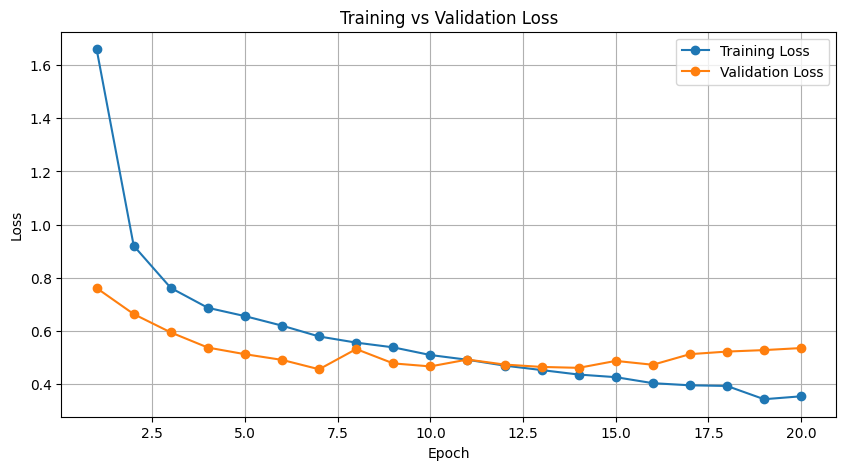

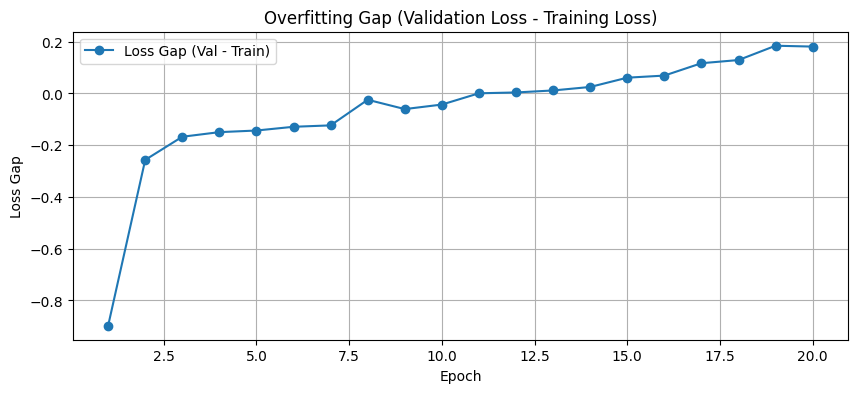

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2387
           1       0.93      0.94      0.93      2375
           2       0.90      0.92      0.91      2580
           3       0.85      0.74      0.79      2668
           4       0.80      0.84      0.82      2348
           5       0.93      0.96      0.94      2393

    accuracy                           0.89     14751
   macro avg       0.89      0.90      0.89     14751
weighted avg       0.89      0.89      0.89     14751



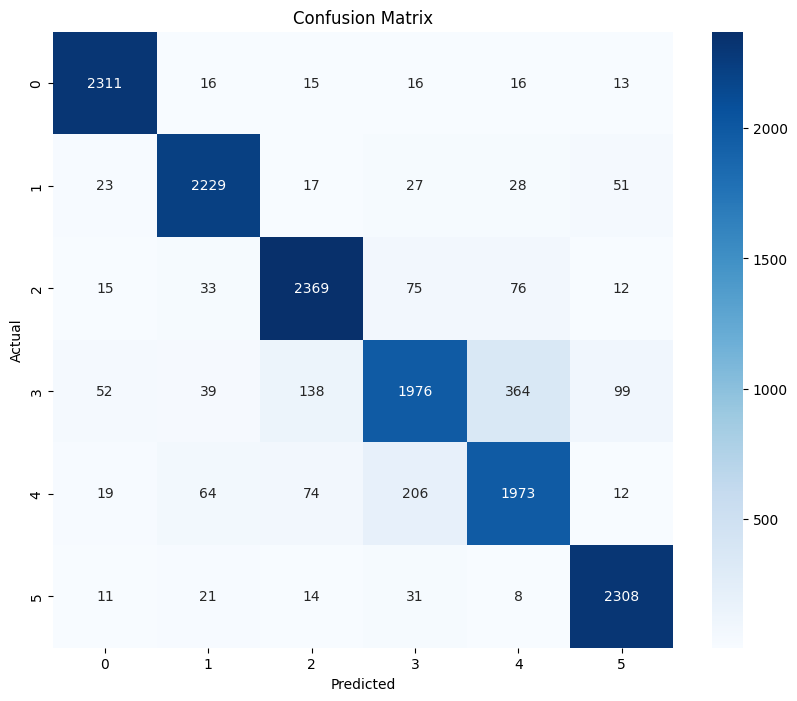

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# ✅ Extract from trainer's log history
log_history = trainer.state.log_history
train_loss = [x['loss'] for x in log_history if 'loss' in x]
val_loss = [x['eval_loss'] for x in log_history if 'eval_loss' in x]
epochs = list(range(1, len(val_loss) + 1))

# ✅ Calculate overfitting gap (only where both losses exist)
loss_gap = [val - train for val, train in zip(val_loss, train_loss[:len(val_loss)])]

# 🔹 Plot: Training vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss[:len(val_loss)], label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# 🔹 Plot: Overfitting Gap
plt.figure(figsize=(10, 4))
plt.plot(epochs, loss_gap, marker='o', label='Loss Gap (Val - Train)')
plt.xlabel("Epoch")
plt.ylabel("Loss Gap")
plt.title("Overfitting Gap (Validation Loss - Training Loss)")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Classification Report + Confusion Matrix
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# 🔹 Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# 🔹 Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [17]:
# ✅ Trial setup
trial_params = {
    'learning_rate': 2e-5,
    'num_train_epochs': 15,
    'per_device_train_batch_size': 32,
    'weight_decay': 0.05,
    'warmup_ratio': 0.1
}

set_seed(42)
trial_args = TrainingArguments(
    output_dir="./trial_final",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=trial_params['learning_rate'],
    per_device_train_batch_size=trial_params['per_device_train_batch_size'],
    per_device_eval_batch_size=64,
    num_train_epochs=trial_params['num_train_epochs'],
    weight_decay=trial_params['weight_decay'],
    warmup_ratio=trial_params['warmup_ratio'],
    logging_dir="./logs/trial_final",
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    greater_is_better=True,
    disable_tqdm=False,
    fp16=True
)

trainer = WeightedLossTrainer(
    model_init=model_init,
    args=trial_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# ✅ Train
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
1,0.860200,0.748621,0.727311,0.713315,0.719548,0.727311
2,0.639100,0.645019,0.758410,0.740727,0.754309,0.758410
3,0.537800,0.595565,0.767816,0.748264,0.772846,0.767816
4,0.482900,0.550645,0.804932,0.800542,0.800937,0.804932
5,0.425900,0.526367,0.817388,0.810671,0.811127,0.817388
6,0.386800,0.494438,0.826710,0.822106,0.822623,0.826710
7,0.347400,0.454320,0.839844,0.836477,0.837442,0.839844
8,0.310400,0.493409,0.837387,0.830435,0.836662,0.837387
9,0.294100,0.481075,0.851284,0.847605,0.848437,0.851284
10,0.260600,0.450483,0.858826,0.855102,0.857481,0.858826


TrainOutput(global_step=22140, training_loss=0.384949510551942, metrics={'train_runtime': 13137.8724, 'train_samples_per_second': 53.893, 'train_steps_per_second': 1.685, 'total_flos': 4.657528946094336e+16, 'train_loss': 0.384949510551942, 'epoch': 15.0})

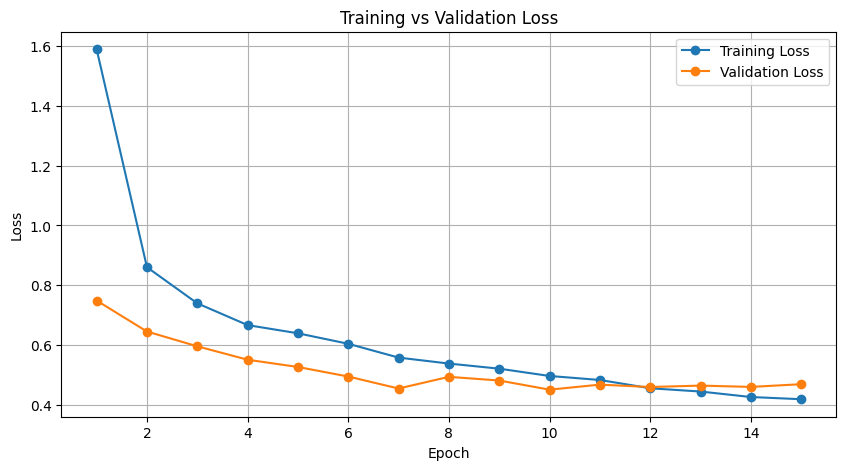

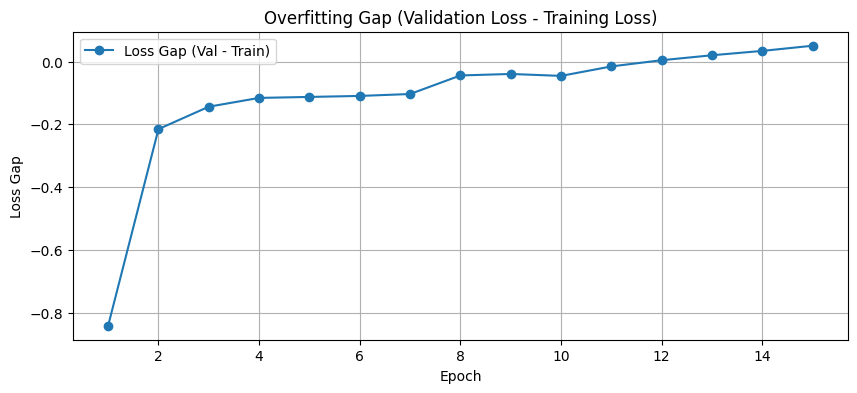

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      2387
           1       0.90      0.95      0.93      2375
           2       0.90      0.90      0.90      2580
           3       0.81      0.70      0.75      2668
           4       0.76      0.82      0.79      2348
           5       0.92      0.96      0.94      2393

    accuracy                           0.88     14751
   macro avg       0.88      0.88      0.88     14751
weighted avg       0.88      0.88      0.87     14751



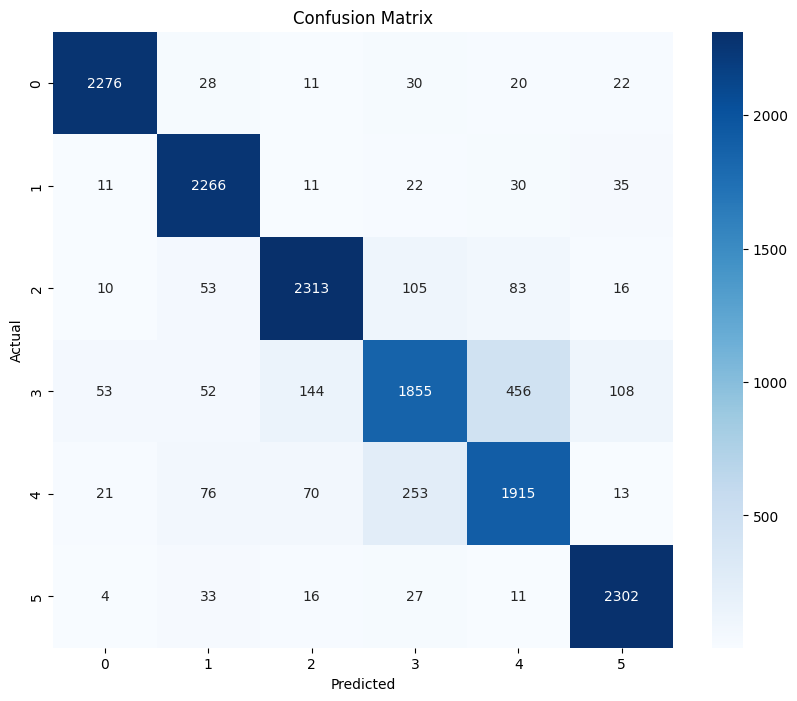

In [19]:
# ✅ Extract from trainer's log history
log_history = trainer.state.log_history
train_loss = [x['loss'] for x in log_history if 'loss' in x]
val_loss = [x['eval_loss'] for x in log_history if 'eval_loss' in x]
epochs = list(range(1, len(val_loss) + 1))

# ✅ Calculate overfitting gap (only where both losses exist)
loss_gap = [val - train for val, train in zip(val_loss, train_loss[:len(val_loss)])]

# 🔹 Plot: Training vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss[:len(val_loss)], label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# 🔹 Plot: Overfitting Gap
plt.figure(figsize=(10, 4))
plt.plot(epochs, loss_gap, marker='o', label='Loss Gap (Val - Train)')
plt.xlabel("Epoch")
plt.ylabel("Loss Gap")
plt.title("Overfitting Gap (Validation Loss - Training Loss)")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Classification Report + Confusion Matrix
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# 🔹 Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# 🔹 Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [24]:
from transformers import BertForSequenceClassification

# Replace this with the actual path to your checkpoint from epoch 12
model = BertForSequenceClassification.from_pretrained("./trial_final/checkpoint-17712")
model.to("cuda") 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [25]:
trainer.model = model


📊 Classification Report (Epoch 12):
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      2387
           1       0.90      0.94      0.92      2375
           2       0.88      0.90      0.89      2580
           3       0.78      0.70      0.74      2668
           4       0.78      0.77      0.77      2348
           5       0.91      0.97      0.94      2393

    accuracy                           0.87     14751
   macro avg       0.87      0.87      0.87     14751
weighted avg       0.87      0.87      0.87     14751



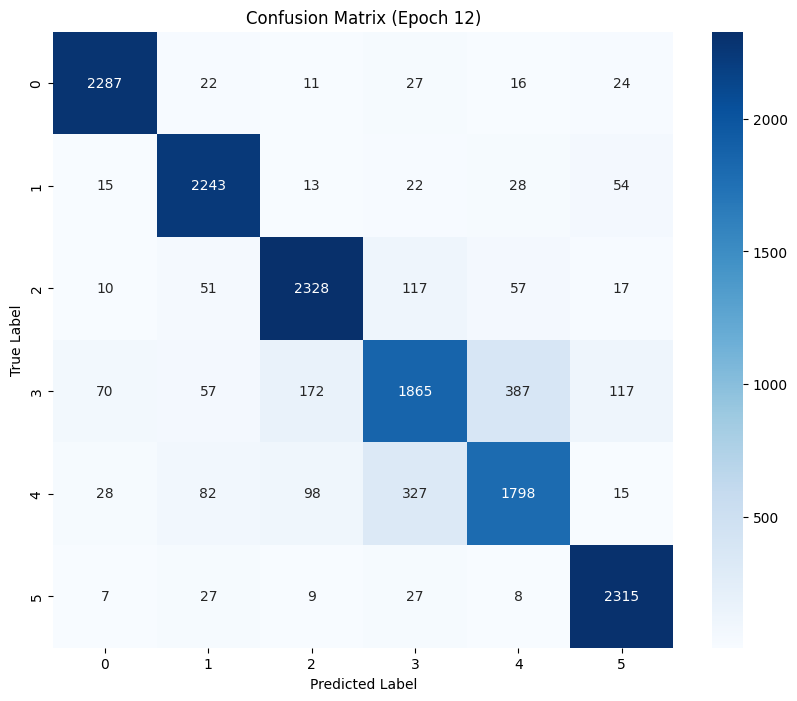

In [26]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Run inference
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# Print classification report
print("📊 Classification Report (Epoch 12):")
print(classification_report(y_true, y_pred))

# Plot confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Epoch 12)")
plt.show()


In [27]:
from sklearn.metrics import classification_report, confusion_matrix

# Run prediction on test set
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# Assuming you have label_encoder used during training
class_names = label_encoder.classes_

# Convert numeric labels to class names
true_labels = [class_names[i] for i in y_true]
pred_labels = [class_names[i] for i in y_pred]


In [28]:
# Get the test text list used for predictions
test_texts = test_dataset["text"] if "text" in test_dataset.column_names else df.loc[test_dataset["labels"].numpy()].tolist()

# Collect misclassified samples
misclassified = [
    {
        "text": text,
        "true_label": true,
        "predicted_label": pred
    }
    for text, true, pred in zip(test_texts, true_labels, pred_labels)
    if true != pred
]

# Convert to DataFrame
df_misclassified = pd.DataFrame(misclassified)

df_misclassified_class3 = df_misclassified[df_misclassified["true_label"] == "other_cyberbullying"]

pd.set_option("display.max_colwidth", None)
df_misclassified_class3.sample(10)



,text,true_label,predicted_label
709,"<user> haha. sebarang fixasi agak menakutkan, sejujurnya..jika orang ingin membenci saya,itu tidak mengapa.tapi sama seperti. mempunyai minat lain.",other_cyberbullying,gender
304,Adakah restoran segera lain di sekitar? Apa yang terjadi?,other_cyberbullying,not_cyberbullying
1706,Terima kasih kerana menunjukkannya. Saya masih belajar semasa saya pergi.,other_cyberbullying,age
402,atau sesuatu yang seumpamanya.. <url>,other_cyberbullying,gender
1822,Ya Allah.. Momen berambut perang untuk pembunuh yang mempunyai personaliti <user> mkr,other_cyberbullying,gender
1857,Juara-juara kebangsaan!! <url>,other_cyberbullying,not_cyberbullying
316,<user> Saya fikir wanita mendapat lebih banyak pilihan untuk kasut.,other_cyberbullying,gender
1310,<user> Saya pasti akan berada di sana pada hari Rabu,other_cyberbullying,not_cyberbullying
492,Siapa yang nak ambil risiko dekat ESR dan tak approve komen aku? Padahal dah tolak pendapat pasal pendidikan.,other_cyberbullying,not_cyberbullying
1306,"Jika kucing kelihatan seperti katak, kita akan sedar betapa jahat dan kejamnya mereka. Saya menulis alat untuk mengelakkan orang daripada mendengar luahan kebencian yang diisi dengan perkataan kasar. Saya percaya bahawa wanita secara umum menghadapi masalah dalam membincangkan wang untuk aktivisme. Banyak artikel mengenai ini. <url> maine coon babys<url ><u | bayi yang dipanggil utama saya adalah pengguna dan pelanggan mereka sangat mengagumkan. ini hebat. Saya tidak mencari bakat asing di luar organisasi anti-gangguan saya. Oh Tuhan, adakah itu yang terjadi? Saya terus menekan butang yang salah. <user> ya..nama anjing saya lain ialah leo. <happy> <user>, oh anda boleh betul dan tidak cuba membulinya dengan ikhlas. feminazi adalah penyelamat masa yang sebenar, kerana seseorang mengatakan bahawa ia hanya membebaskan anda daripada mendengar mereka selama-lamanya. . "" <url>",other_cyberbullying,gender


In [30]:
# Assuming you already did:
# predictions = trainer.predict(test_dataset)
# y_true = predictions.label_ids
# y_pred = np.argmax(predictions.predictions, axis=1)

# Load full test texts from original split
df = pd.read_csv("final_balanced_dataset_v2.csv")
test_texts = df["tweet_text"].tolist()[-len(y_true):]  # match test set size

# Filter misclassified for class 3 & 4
mask = ((y_true == 3) & (y_pred != 3)) | ((y_true == 4) & (y_pred != 4))
misclassified_df = pd.DataFrame({
    "text": np.array(test_texts)[mask],
    "true_label": y_true[mask],
    "predicted_label": y_pred[mask]
})

# Optional: decode labels
from joblib import load
label_encoder = load("cyberbullying_model/cyber_label_encoder.pkl")
misclassified_df["true_label"] = label_encoder.inverse_transform(misclassified_df["true_label"])
misclassified_df["predicted_label"] = label_encoder.inverse_transform(misclassified_df["predicted_label"])

# Save or view
misclassified_df.to_csv("misclassified_class_3_4.csv", index=False)
print("Saved to misclassified_class_3_4.csv")


Saved to misclassified_class_3_4.csv


In [ ]:
# ✅ Train
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
1,0.871200,0.767593,0.726975,0.712166,0.713881,0.726975
2,0.627500,0.625431,0.766510,0.748281,0.768076,0.766510
3,0.556200,0.573607,0.790444,0.781347,0.786459,0.790444
4,0.493900,0.530108,0.809857,0.803776,0.807343,0.809857
5,0.443200,0.491903,0.822977,0.820153,0.818798,0.822977
6,0.404200,0.473532,0.833437,0.830419,0.830668,0.833437
7,0.377500,0.489727,0.834146,0.829979,0.828673,0.834146
8,0.336500,0.484655,0.845404,0.842042,0.842474,0.845404
9,0.306500,0.441667,0.854800,0.852112,0.851531,0.854800
10,0.282600,0.435460,0.859764,0.857538,0.858827,0.859764


TrainOutput(global_step=21165, training_loss=0.4056079672550496, metrics={'train_runtime': 12719.0246, 'train_samples_per_second': 53.215, 'train_steps_per_second': 1.664, 'total_flos': 4.452294952325376e+16, 'train_loss': 0.4056079672550496, 'epoch': 15.0})

In [23]:
from transformers import TrainingArguments

# ⬇️ Step 1: Define new args (with 20 epochs now)
new_args = TrainingArguments(
    output_dir="./trial_final",
    num_train_epochs=20,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=trial_params['learning_rate'],
    per_device_train_batch_size=trial_params['per_device_train_batch_size'],
    per_device_eval_batch_size=64,
    weight_decay=trial_params['weight_decay'],
    warmup_ratio=trial_params['warmup_ratio'],
    logging_dir="./logs/trial_final",
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    greater_is_better=True,
    disable_tqdm=False,
    fp16=True
)

# ⬇️ Step 2: Recreate trainer object with new args
trainer = WeightedLossTrainer(
    model_init=model_init,
    args=new_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ⬇️ Step 3: Resume from last checkpoint and continue training
trainer.train(resume_from_checkpoint="./trial_final/checkpoint-21165")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
16,0.208500,0.474783,0.868175,0.866257,0.867732,0.868175
17,0.200100,0.484156,0.871933,0.871219,0.871278,0.871933
18,0.188700,0.509002,0.869309,0.867754,0.868424,0.869309
19,0.169000,0.502344,0.872784,0.871356,0.871400,0.872784
20,0.169700,0.501336,0.873990,0.872605,0.873332,0.873990


TrainOutput(global_step=28220, training_loss=0.04662402630866123, metrics={'train_runtime': 6732.1722, 'train_samples_per_second': 134.052, 'train_steps_per_second': 4.192, 'total_flos': 5.936393269767168e+16, 'train_loss': 0.04662402630866123, 'epoch': 20.0})

In [24]:
from transformers import TrainingArguments

# ⬇️ Step 1: Define new args (with 20 epochs now)
new_args = TrainingArguments(
    output_dir="./trial_final",
    num_train_epochs=30,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=trial_params['learning_rate'],
    per_device_train_batch_size=trial_params['per_device_train_batch_size'],
    per_device_eval_batch_size=64,
    weight_decay=trial_params['weight_decay'],
    warmup_ratio=trial_params['warmup_ratio'],
    logging_dir="./logs/trial_final",
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    greater_is_better=True,
    disable_tqdm=False,
    fp16=True
)

# ⬇️ Step 2: Recreate trainer object with new args
trainer = WeightedLossTrainer(
    model_init=model_init,
    args=new_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# ⬇️ Step 3: Resume from last checkpoint and continue training
trainer.train(resume_from_checkpoint="./trial_final/checkpoint-28220")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
21,0.194000,0.483622,0.872784,0.871617,0.871719,0.872784
22,0.189200,0.469119,0.877890,0.877489,0.877979,0.877890
23,0.164800,0.506850,0.875195,0.873751,0.874902,0.875195
24,0.152400,0.521182,0.877181,0.875904,0.876940,0.877181
25,0.156600,0.538830,0.877322,0.876274,0.878687,0.877322


TrainOutput(global_step=35275, training_loss=0.0339346591400644, metrics={'train_runtime': 6455.4263, 'train_samples_per_second': 209.698, 'train_steps_per_second': 6.557, 'total_flos': 7.42049158720896e+16, 'train_loss': 0.0339346591400644, 'epoch': 25.0})

In [29]:
for i, log in enumerate(trainer.state.log_history):
    if 'eval_loss' in log:
        print(f"Eval Epoch {log['epoch']:.0f} → Checkpoint-{trainer.state.global_step}: Val Loss = {log['eval_loss']:.4f}")

Eval Epoch 1 → Checkpoint-35275: Val Loss = 0.7676
Eval Epoch 2 → Checkpoint-35275: Val Loss = 0.6254
Eval Epoch 3 → Checkpoint-35275: Val Loss = 0.5736
Eval Epoch 4 → Checkpoint-35275: Val Loss = 0.5301
Eval Epoch 5 → Checkpoint-35275: Val Loss = 0.4919
Eval Epoch 6 → Checkpoint-35275: Val Loss = 0.4735
Eval Epoch 7 → Checkpoint-35275: Val Loss = 0.4897
Eval Epoch 8 → Checkpoint-35275: Val Loss = 0.4847
Eval Epoch 9 → Checkpoint-35275: Val Loss = 0.4417
Eval Epoch 10 → Checkpoint-35275: Val Loss = 0.4355
Eval Epoch 11 → Checkpoint-35275: Val Loss = 0.4727
Eval Epoch 12 → Checkpoint-35275: Val Loss = 0.4605
Eval Epoch 13 → Checkpoint-35275: Val Loss = 0.4657
Eval Epoch 14 → Checkpoint-35275: Val Loss = 0.4655
Eval Epoch 15 → Checkpoint-35275: Val Loss = 0.4670
Eval Epoch 16 → Checkpoint-35275: Val Loss = 0.4748
Eval Epoch 17 → Checkpoint-35275: Val Loss = 0.4842
Eval Epoch 18 → Checkpoint-35275: Val Loss = 0.5090
Eval Epoch 19 → Checkpoint-35275: Val Loss = 0.5023
Eval Epoch 20 → Check

In [ ]:
model = BertForSequenceClassification.from_pretrained("./trial_final/checkpoint-35275")

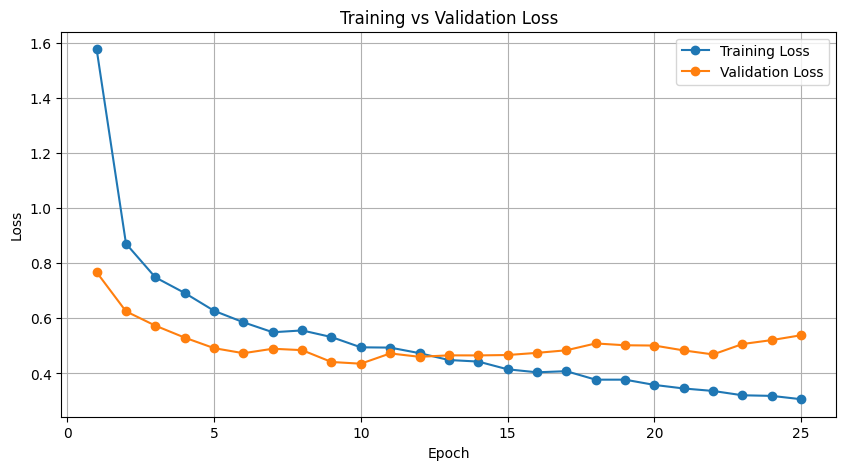

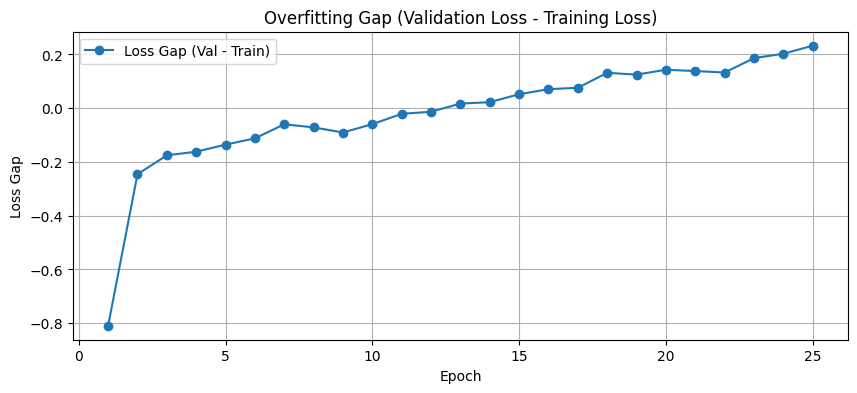

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2387
           1       0.94      0.92      0.93      2375
           2       0.87      0.91      0.89      2309
           3       0.79      0.72      0.75      2458
           4       0.76      0.81      0.78      2179
           5       0.95      0.95      0.95      2394

    accuracy                           0.88     14102
   macro avg       0.88      0.88      0.88     14102
weighted avg       0.88      0.88      0.88     14102



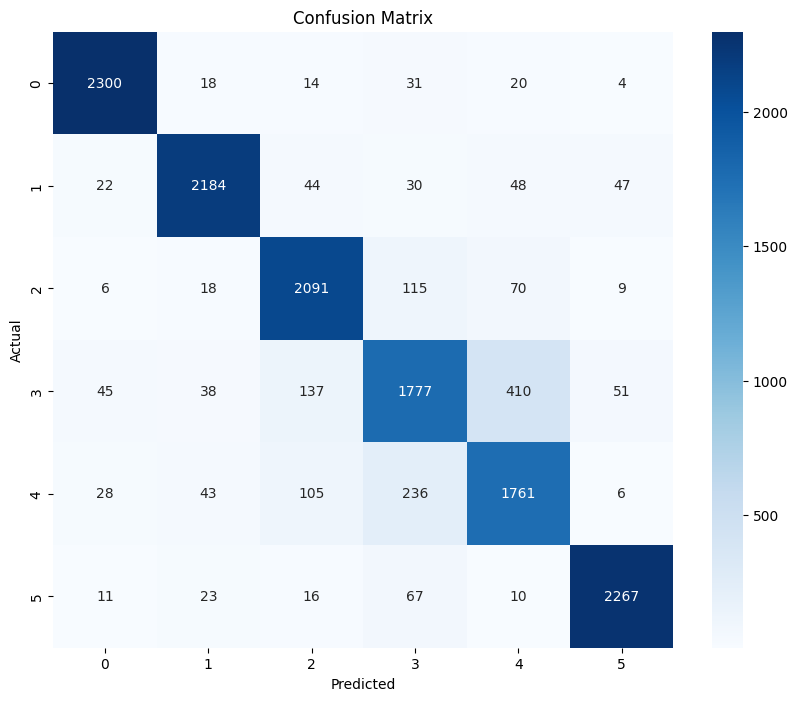

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# ✅ Extract from trainer's log history
log_history = trainer.state.log_history
train_loss = [x['loss'] for x in log_history if 'loss' in x]
val_loss = [x['eval_loss'] for x in log_history if 'eval_loss' in x]
epochs = list(range(1, len(val_loss) + 1))

# ✅ Calculate overfitting gap (only where both losses exist)
loss_gap = [val - train for val, train in zip(val_loss, train_loss[:len(val_loss)])]

# 🔹 Plot: Training vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss[:len(val_loss)], label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# 🔹 Plot: Overfitting Gap
plt.figure(figsize=(10, 4))
plt.plot(epochs, loss_gap, marker='o', label='Loss Gap (Val - Train)')
plt.xlabel("Epoch")
plt.ylabel("Loss Gap")
plt.title("Overfitting Gap (Validation Loss - Training Loss)")
plt.legend()
plt.grid(True)
plt.show()

# ✅ Classification Report + Confusion Matrix
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# 🔹 Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# 🔹 Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [43]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import joblib
import os

# Reload your original data
df = pd.read_csv("final_balanced_dataset.csv")

# Refit LabelEncoder on string labels
label_encoder = LabelEncoder()
label_encoder.fit(df["cyberbullying_type"])

# Save for future use
os.makedirs("./cyberbullying_model", exist_ok=True)
joblib.dump(label_encoder, "./cyberbullying_model/cyber_label_encoder.pkl")

# Show mapping
print("✅ Label Mapping (Recovered):")
for idx, label in enumerate(label_encoder.classes_):
    print(f"{idx}: {label}")


✅ Label Mapping (Recovered):
0: age
1: ethnicity
2: gender
3: not_cyberbullying
4: other_cyberbullying
5: religion


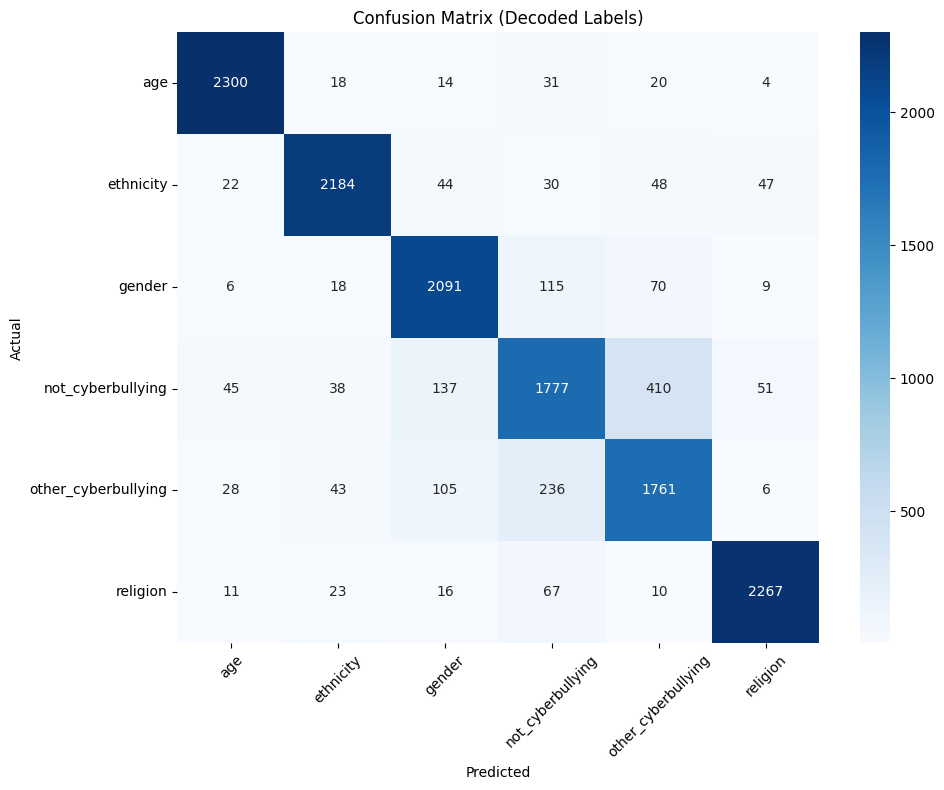

In [44]:
# 🔍 Label names from saved encoder
label_names = label_encoder.classes_  # Already fitted earlier

# 🔹 Confusion matrix with decoded labels
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Decoded Labels)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


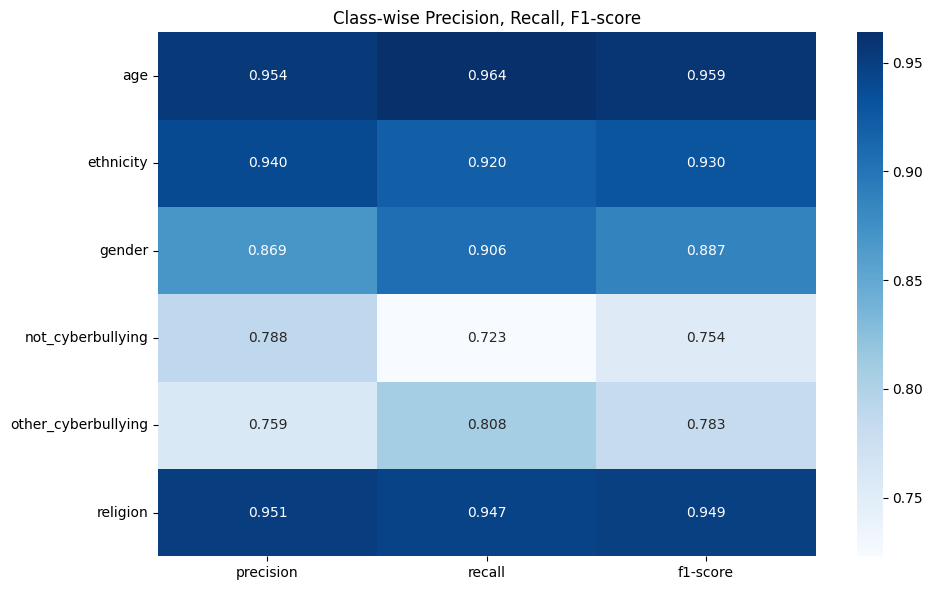

In [45]:
from sklearn.metrics import classification_report
import pandas as pd

report_dict = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.round(3)  # Neater formatting

# 🔍 Display class-wise metrics
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-3, :-1], annot=True, cmap='Blues', fmt='.3f')
plt.title("Class-wise Precision, Recall, F1-score")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [48]:
# Assuming df_test is your original test dataframe (with text and label)
df_test = pd.DataFrame({
    "text": test_texts.reset_index(drop=True),
    "true_label": label_encoder.inverse_transform(y_true),
    "predicted_label": label_encoder.inverse_transform(y_pred)
})

# 🔍 Filter misclassified class 3 as example
mistakes_class_3 = df_test[(df_test["true_label"] == "age") & 
                           (df_test["predicted_label"] != "age")]

# Show first few mistakes
print("❌ Misclassified Class 3 Examples:")
print(mistakes_class_3.head(10))


❌ Misclassified Class 3 Examples:
                                                   text true_label  \
777   Semua orang tweet 'ini tweets / your tweeted/ ...        age   
985   Tidak, saya benar-benar merasakan ini. Saya me...        age   
987   Semasa di sekolah rendah, apabila seseorang me...        age   
1049  Ambil tindakan: Berdiri dengan pengganas tanda...        age   
1067  <user> Anda adalah seorang ratchet lama yang t...        age   
1426  Berhati-hatilah dengan anak anda. Pengintim sa...        age   
1623  Dido telah dibuli semasa kecil kerana dipanggi...        age   
1648  Seperti yang kita semua telah wujudkan, saya k...        age   
1649  Jimmy bukanlah seorang pengganas yang tidak so...        age   
1659  Saya tidak mempunyai jenama atau model kereta ...        age   

          predicted_label  
777   other_cyberbullying  
985   other_cyberbullying  
987             ethnicity  
1049    not_cyberbullying  
1067  other_cyberbullying  
1426    not_cyberbullying  

In [34]:
model.save_pretrained("./cyberbullying_model")
tokenizer.save_pretrained("./cyberbullying_tokenizer")

('./cyberbullying_tokenizer\\tokenizer_config.json',
 './cyberbullying_tokenizer\\special_tokens_map.json',
 './cyberbullying_tokenizer\\vocab.txt',
 './cyberbullying_tokenizer\\added_tokens.json')

In [35]:
import joblib
joblib.dump(label_encoder, "cyber_label_encoder.pkl")  # Save encoder

['cyber_label_encoder.pkl']

In [32]:
import shutil
import os

# Get disk usage for the drive where this script is running (e.g., C:\)
total, used, free = shutil.disk_usage(os.getcwd())

def format_size(bytes):
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if bytes < 1024:
            return f"{bytes:.2f} {unit}"
        bytes /= 1024
    return f"{bytes:.2f} PB"

print(f"📁 Current Drive: {os.getcwd()}")
print(f"🗃️  Total Disk Space:     {format_size(total)}")
print(f"📦 Used Disk Space:      {format_size(used)}")
print(f"🟢 Free Disk Space:      {format_size(free)}")


📁 Current Drive: c:\Users\MMU\Downloads\FYP_Prototype\FYP_Prototype\model
🗃️  Total Disk Space:     475.51 GB
📦 Used Disk Space:      416.79 GB
🟢 Free Disk Space:      58.72 GB
